In [ ]:
!pip install transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import fastai
import re
import pickle
import string

print(torch.__version__)
print(transformers.__version__)
print( fastai.__version__)

1.13.1+cu116
4.27.3
2.7.11


In [4]:
class DropOutput(Callback):
    def after_pred(self):
        self.learn.pred = self.pred[0]

class TransformersTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def encodes(self, x):
        tok = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(tok))

    def decodes(self, x):
        return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
#download model and tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")
#test tokenizer
# print(tokenizer.tokenize("안녕하세요. 한국어 GPT-2 입니다.😤:)l^o"))

#test model ouput
# text = """위치추적 전자장치(전자발찌) 훼손 전후로 여성 2명을 잇달아 살해한 """
# input_ids = tokenizer.encode(text)
# gen_ids = model.generate(torch.tensor([input_ids]),
#                            max_length=128,
#                            repetition_penalty=2.0,
#                            pad_token_id=tokenizer.pad_token_id,
#                            eos_token_id=tokenizer.eos_token_id,
#                            bos_token_id=tokenizer.bos_token_id,
#                            use_cache=True
#                         )
# generated = tokenizer.decode(gen_ids[0,:].tolist())
# print(generated)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/usr/local/lib/python3.9/dist-packages/transformers/models/auto/modeling_auto.py:1295: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [7]:
with open('/content/drive/MyDrive/Colab Notebooks/train.txt', 'rb') as f:
    train = pickle.load(f)

with open('./drive/MyDrive/Colab Notebooks/validation.txt', 'rb') as f:
    valid = pickle.load(f)

In [8]:
tr = pd.DataFrame()
vl = pd.DataFrame()
ttl = pd.DataFrame()

vl['text'] = valid
tr['text'] = train

ttl = pd.concat([tr, vl]).reset_index(drop = True)

In [12]:
print(len(tr), len(vl))
print(f'총 데이터셋 크기 : {len(ttl)}')
ttl.head(1)

136016 17002
총 데이터셋 크기 : 153018


,text
0,"익산시 서부권역 다목적 체육관이 내달 개관을 앞두고 막바지 개관 준비가 한창이다. \n\n시에 따르면 시민들의 건강증진과 삶의 질 향상을 위한 생활체육 인프라 확충 등을 위해 지난 2019년 착공된 서부권역 다목적 체육관이 이달 말까지 시설물 준공을 완료하고 다음달부터 본격적인 개관 운영에 들어간다. \n\n전문 체육시설인 서부권역 다목적 체육관은 지하 1층과 지상 3층, 연면적 4719㎡ 규모로 총 사업비 124억5000만원이 투입됐다. \n\n수영장 6개 레인과 어린이풀장, 다목적실(에어로빅, 요가 등), 체력단련실, 어르신들을 위한 물리ㆍ재활 운동실 등이 들어서며, 수영, 헬스, 요가, 에어로빅, 아쿠아로빅 등 총 5가지 프로그램이 운영될 예정이다. \n\n첫 번째로 개관되는 시설은 헬스장이다. \n\n다음달 중순부터 회원 신청이 가능하며 체육관에 방문해 신청하면 된다. \n\n아울러 시는 코로나19 예방을 위해 소독작업은 물론 체육관 운영시간과 참여 인원을 축소해 운영하는 방안을 계획하고 있다. \n\n체육관 전체 소독은 하루 3회로 먼저 개관되는 헬스장의 경우 오후 1시부터 2시까지 1시간 동안 브레이크타임을 도입해 기구와 라커룸 등의 소독작..."


In [14]:
def learner_func(DATA,
                 SPLIT_RATIO,
                 TOKENIZER,
                 MODEL,
                 MODEL_NAME,
                 EPOCH = 5):

    # Randomly Indexing
    num = int(SPLIT_RATIO * len(DATA))

    idxs = np.random.randint(0, len(DATA), len(DATA))
    idxs_train = idxs[:num]
    idxs_val = idxs[num:]

    all_text = np.concatenate([DATA.iloc[idxs_train].text.values, DATA.iloc[idxs_val].text.values])
    print(f'Length of Dataset: {len(all_text)}')

    splits = [list(idxs_train), list(idxs_val)]

    # Setting Dataset
    tls = TfmdLists(all_text, TransformersTokenizer(TOKENIZER), splits = splits, dl_type = LMDataLoader)

    # Params
    batch, seq_len = 8, 256

    # Dataloader
    dls = tls.dataloaders(bs = batch, seq_len = seq_len)

    # Fitting
    print('------------------------Fitting ----------------------------')
    learn = Learner(dls,
                    MODEL,
                    loss_func = CrossEntropyLossFlat(),
                    cbs = [DropOutput],
                    metrics = Perplexity()
                    ).to_fp16()
    lr = learn.lr_find()
    print(lr)
    learn.fit_one_cycle(EPOCH, lr)
    print('-------------------- Fitting Complete -----------------------')

    # Model Save
    # learn.save(f'/content/drive/MyDrive/Colab Notebooks/{MODEL_NAME}')  ## .pt
    learn.model.save_pretrained(f'/content/drive/MyDrive/Colab Notebooks/{MODEL_NAME}')  ## pytorch_model.bin + generation_config.json + config.json

Length of Dataset: 153018
------------------------Fitting ----------------------------


SuggestedLRs(valley=0.0002290867705596611)


epoch,train_loss,valid_loss,perplexity,time


epoch,train_loss,valid_loss,perplexity,time
0,3.587456,3.326792,27.848866,3:04:54


-------------------- Fitting Complete -----------------------


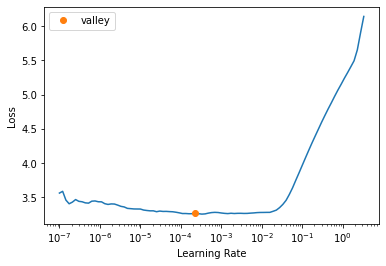

In [15]:
learner_func(ttl, 0.8, tokenizer, model, 'kogpt2_newpaper_153k_1epochs', EPOCH = 1)

In [18]:
# model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")

output_model_file = '/content/drive/MyDrive/Colab Notebooks/kogpt2_newpaper_153k_1epochs/pytorch_model.bin'

state_dict = torch.load(output_model_file)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [19]:
def inference_fn(PROMPT,
                 MAX_LENGTH: int,
                 REPETITION_PENALTY: float,
                 TOP_P: float,
                 TOP_K: int):
    prompt = PROMPT,
    encode = tokenizer.encode(PROMPT)
    inp = tensor(encode)[None].cuda()
    output = model.generate(inp,
                                  pad_token_id = tokenizer.pad_token_id,
                                  eos_token_id = tokenizer.eos_token_id,
                                  bos_token_id = tokenizer.bos_token_id,
                                  max_length = MAX_LENGTH,
                                  repetition_penalty = REPETITION_PENALTY,
                                  top_p = TOP_P,
                                  top_k = TOP_K,
                                  use_cache = True
                                  )
    
    return tokenizer.decode(output[0].cpu().numpy())

In [23]:
prompt = """ 테슬라 주가 전망 """

inference_fn(prompt, 200, 1.2, 0.85, 31)

'테슬라 주가 전망망 섹션에 대한 기대감이 높아지고 있다. \n\n지난해 12월 초 코스피가 사상 최고치를 기록한 뒤 시가총액 상위 종목들의 주가가 급등하면서 투자자들의 관심이 쏠린다. \n\n코스피는 지난달 31일부터 이날까지 나흘 연속 상승세를 이어가며 올 들어서도 4거래일 동안 6조원 가까이 올랐다. \n\n이날 삼성전자와 SK하이닉스, 현대차 등 대형 IT주들이 일제히 강세를 보였다. \n\n특히 최근 반도체 업황 호조로 자동차 부품주가 크게 오른 데 이어 전기전자 업종도 큰 폭으로 뛰어올랐다. \n\n현대자동차와 기아 역시 각각 전 거래일 대비 9.29%, 2.04%씩 치솟았다. \n\nSK하이닉스(1.55%), LG화학(3.32%) 등도 모두 2.11% 이상 뛰었다. \n\n한편 코스닥 지수도 전날보다 7.47포인트(0.96%) 내린 825.88로 마감'